# Week 10 - Introduction to Modeling

# 1. Lesson

Last week, we reviewed one model: linear regression.  This week, we are going to review another, called random forest.  The random forest model builds many decision trees, then averages their estimates to make a prediction.

You will also perform:
* Cross-validation
* Hyperparameter tuning
* A performance metric (root mean squared error)

### How does random forest work?

A random forest is a set of decision trees.  Let's say we use n_estimators = 100 decision trees, and we have ten features.  Then each decision tree is built so that a given branch gets about three (sqrt(10)) features to choose from.  It starts from the top of the tree, selects the best feature, then proceeds to the next nodes.  The best feature is the one that minimizes the mean squared error, which must be computed for both branches, weighted according to the probability of each branch, and then summed over both branches.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error
from scipy.stats import pearsonr

Here, we build three series of random numbers between 0 and 1.  We use a somewhat arbitrary formula to construct the synthetic data.  The fourth value (the target) equals the first series minus twice the second, with the whole then being multiplied by the third series.  If we stopped here, the target would be completely dependent on the three feature series - it would be easy to predict.  However, we then add a random normal distribution to make the prediction harder.

There are a train series and a test series, with different features ("a" and "b"), and with different random normal data added.  This tests whether our model can predict new data.  We fit to the "a" features using the train_target, then predict the test_target using the "b" features.

In [14]:
np.random.seed(0)
num_points = 10000
feature_1a = np.random.random(size = num_points) * 3
feature_2a = np.random.random(size = num_points) * 3
feature_3a = np.random.random(size = num_points) * 3
train_target = (feature_1a - 2 * feature_2a) * feature_3a + np.random.normal(size = num_points)
feature_1b = np.random.random(size = num_points) * 3
feature_2b = np.random.random(size = num_points) * 3
feature_3b = np.random.random(size = num_points) * 3
test_target = (feature_1b - 2 * feature_2b) * feature_3b + np.random.normal(size = num_points)
train_df = pd.DataFrame({"f1": feature_1a, "f2": feature_2a, "f3": feature_3a})
test_df = pd.DataFrame({"f1": feature_1b, "f2": feature_2b, "f3": feature_3b})
rf = RandomForestRegressor()
rf.fit(train_df.values, train_target)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


As expected, the RMSE is smallest when predicting the training data, larger when predicting the testing data, and largest when comparing random (shuffled) data instead of using a prediction.  In the last case, there is no attempt to make a good prediction.  The small RMSE when predicting the training data indicates that the model has "memorized" the training data to some degree.

In [15]:
print("RMSE when predicting training data:")
print(root_mean_squared_error(rf.predict(train_df.values), train_target))
print("RMSE when predicting testing data:")
print(root_mean_squared_error(rf.predict(test_df.values), test_target))
test_target_shuffle = test_target.copy()
np.random.shuffle(test_target_shuffle)
print("RMSE with random predictions:")
print(root_mean_squared_error(test_target_shuffle, test_target))

RMSE when predicting training data:
0.4044649864687342
RMSE when predicting testing data:
1.0666272939687746
RMSE with random predictions:
5.262103337484077


Next, we perform a Grid Search over various parameters.  We've used a small number of parameters here, but you could add more.  The first parameter, n_estimators, shows the number of decision trees in the random forest.  The second, max_depth, is the maximum depth of each tree.  By picking three n_estimators values (10, 33, 100) and three max_depth values (2, 4, None), we allow for nine parameter combinations.  For example, (n_estimators = 10, max_depth = 2) is a combination.  The grid search tries all nine combinations and uses cross validation to choose the best one.  This is done below.

### What is cross validation?

Cross validation is a way to find out which parameter combination is the best.  With 5-fold cross validation (the default) we divide the data into five equal-sized groups.  Four of them are used as training data and the fifth is testing data.  The score (in this case the root mean squared error) on the testing data is recorded.  This is done for each split: that is, each fifth is taken out and used as testing data; then, the five root mean squared errors (from taking out the five fifths, one at a time) are averaged.

We now have root mean squared error value for each parameter combination, allowing us to choose the best combination.

In [16]:
np.random.seed(0)
gcv = GridSearchCV(estimator = RandomForestRegressor(), param_grid = {"n_estimators": [10, 33, 100], "max_depth": [2, 4, None]}, \
                   scoring = "neg_root_mean_squared_error")
gcv.fit(train_df.values, train_target)

,estimator,RandomForestRegressor()
,param_grid,"{'max_depth': [2, 4, ...], 'n_estimators': [10, 33, ...]}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [17]:
print(gcv.best_estimator_)
print(gcv.best_params_)
print(gcv.best_score_)

RandomForestRegressor()
{'max_depth': None, 'n_estimators': 100}
-1.0851473707103607


In [18]:
gcv.cv_results_["mean_test_score"] # There are nine scores, one for each of the 3 x 3 hyperparameter combinations

array([-2.27296628, -2.26369708, -2.26370023, -1.56063403, -1.52732923,
       -1.52615891, -1.12289812, -1.0937049 , -1.08514737])

### Why does n_estimators grow like 10, 33, 100 instead of like 1, 50, 100?

First of all, we can make it grow however we want.  The question is why we chose 10, 33, 100.  The idea here is that when you have no idea what is the appropriate number, you should pick guesses that grow exponentially.  For example, suppose you are trying to guess the height of a particular tree.  You look online and find that redwoods grow to 400 feet high, while bonsai trees may be as short as six inches.  If you get three guesses, you could guess: one foot, 200 feet, 400 feet.  These guesses would be linearly spaced out.  However, the 200 foot guess feels wrong - it's still very tall.  Most trees don't grow that tall.  Instead, let's make a geometric progression:

In [19]:
list(map(round, [400**0, 400**0.25, 400**0.5, 400**0.75, 400*1]))

[1, 4, 20, 89, 400]

Now the guesses are four feet, 20 feet, and 89 feet.  (We'll drop the initial 1 and the final 400.) That feels more plausible: the middle value, 20 feet, is representative of many actual trees in a way that the middle 200 foot guess wasn't.

# 2. Weekly graph question

In words, please summarize what this graph shows.

In [20]:
rmse_lst = list()
for x in range(round(num_points / 20), num_points, round(num_points / 20)):
    rf.fit(train_df.values[0:x,:], train_target[0:x])
    rmse_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

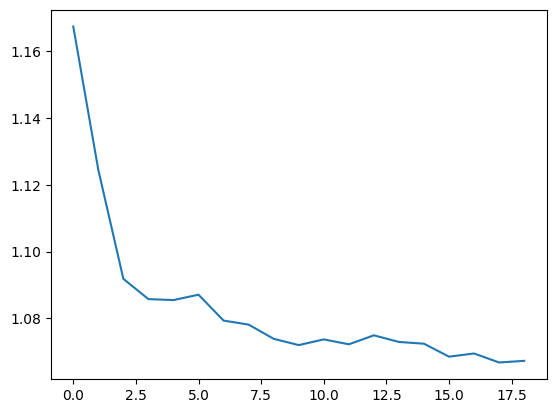

In [21]:
import matplotlib.pyplot as plt

plt.plot(rmse_lst)

**My Answer**

As the size of the training data increases, the RMSE decreases initially, indicating improved model performance. Eventually, the RMSE levels off, suggesting that adding more data yields diminishing returns in prediction accuracy. This trend reflects a typical learning curve: more data helps at first, but the benefit plateaus.



# 3. Homework

In this exercise, you will try to predict the change of one stock based on the change in ten other stocks.

In [22]:
def make_X_y(alpha = 0.5):
    df_hwk = pd.DataFrame()
    num_samples_hwk = 10000
    common_odd = np.random.normal(size = num_samples_hwk)
    common_even = np.random.normal(size = num_samples_hwk)
    common_three = np.random.normal(size = num_samples_hwk)
    for n in range(11):
        common = np.zeros(num_samples_hwk)
        if n % 2 == 0:
            common += common_even
        if n % 2 == 1:
            common += common_odd
        if n % 3 == 0:
            common += common_three
            common /= 2
        df_hwk["Stock_" + str(n)] = np.random.normal(size = num_samples_hwk) + alpha * common
    X = df_hwk.values[:,:-1]
    y = df_hwk.values[:,-1]
    return X, y

The above code creates an X with ten columns, corresponding to ten different stocks.  The y is the eleventh stock.  The stocks have some commonalities: the even numbered stocks are related, as are the odds.  The stocks that are multiples of three are all related, too.  Random forest should be able to sort through all this and decide that the eleventh stock is related to the odd numbered, non-divisible-by-three stocks, and predict accordingly.  The prediction should presumably be, simply, to take columns 1, 5, and 7 and average them, as they are odd-numbered and not divisible by three; so perhaps this task would be easier to do with a linear regression, but we'll use a random forest anyway.  The value "alpha" determines how important the common element is.  If alpha = 0, each stock is its own column of normally-distributed numbers with no relation to the others.  If alpha = 10, then the great majority of the variation in the stock values comes from the common elements.

### Question: 

Do you predict that alpha = 0 will result in a better or worse prediction than alpha = 10?  Remember that the prediction must be performed on test data, so you'll need an X_train and y_train for training and a separate X_test and y_test for testing.  I recommend using a correlation rather than a MSE or RMSE in this case, if you want to directly compare two different predictions, because the MSE and RMSE vary with the magnitude of the data as well as with the quality of the prediction.

After you make the prediction, try it out, and comment on what you learned.


### Randomized Search

Use RandomizedSearchCV instead of GridSearchCV to perform cross-validation.

### Scoring

Research the scoring parameters under "regression":

https://scikit-learn.org/dev/modules/model_evaluation.html#scoring-parameter

Choose at least one that you want to learn about, use it, and research it online.  Write something about what you've learned about it.

**My Answer/Prediction**
I predict that alpha = 0 will result in a worse prediction than alpha = 10.
When alpha = 0, there is no shared structure among the stocks ,each one is just random noise ,so the target stock (Stock_10) cannot be meaningfully predicted from the others.

In [ ]:
np.random.seed(0)

# Create data with alpha = 10
X, y = make_X_y(alpha=10)
train_df, test_df, train_target, test_target = train_test_split(X, y, test_size=0.3, random_state=0)

# Set up param distributions
param_dist = {
    "n_estimators": [10, 33, 100, 150],
    "max_depth": [2, 4, 6, None],
    "min_samples_split": [2, 4, 6],
    "min_samples_leaf": [1, 2, 3]
}

# Run RandomizedSearchCV
rsearch = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=0),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring="neg_mean_absolute_error",
    random_state=0
)

# Fit the model to training data
rsearch.fit(train_df, train_target)

# Use best estimator to predict
best_model = rsearch.best_estimator_
predictions = best_model.predict(test_df)

# Evaluate using Pearson correlation
corr, _ = pearsonr(test_target, predictions)

# Print results 
print("Best Estimator:")
print(rsearch.best_estimator_)
print("\nBest Parameters:")
print(rsearch.best_params_)
print("\nBest CV Score (neg MAE):")
print(rsearch.best_score_)
print(f"\nPearson Correlation on Test Data: {corr:.3f}")


Best Estimator:
RandomForestRegressor(max_depth=6, min_samples_leaf=2, min_samples_split=4,
                      n_estimators=33, random_state=0)

Best Parameters:
{'n_estimators': 33, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 6}

Best CV Score (neg MAE):
-0.9522505833460665

Pearson Correlation on Test Data: 0.992


In [ ]:
# Generate data with alpha = 0 
X_zero, y_zero = make_X_y(alpha=0)
train_df_zero, test_df_zero, train_target_zero, test_target_zero = train_test_split(
    X_zero, y_zero, test_size=0.3, random_state=0)


rsearch_zero = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=0),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='neg_mean_absolute_error',
    random_state=0
)

# Fit model on alpha=0 data
rsearch_zero.fit(train_df_zero, train_target_zero)

# Predict and evaluate
best_model_zero = rsearch_zero.best_estimator_
predictions_zero = best_model_zero.predict(test_df_zero)
corr_zero, _ = pearsonr(test_target_zero, predictions_zero)

print("Best Estimator (alpha=0):")
print(rsearch_zero.best_estimator_)
print("\nBest Parameters (alpha=0):")
print(rsearch_zero.best_params_)
print("\nBest CV Score (neg MAE, alpha=0):")
print(rsearch_zero.best_score_)
print(f"\nPearson Correlation on Test Data (alpha=0): {corr_zero:.3f}")


Best Estimator (alpha=0):
RandomForestRegressor(max_depth=2, min_samples_split=4, n_estimators=150,
                      random_state=0)

Best Parameters (alpha=0):
{'n_estimators': 150, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 2}

Best CV Score (neg MAE, alpha=0):
-0.8063957122874307

Pearson Correlation on Test Data (alpha=0): 0.029


When comparing the model’s performance at alpha = 0 and alpha = 10, the difference is striking. At alpha = 0, there is no shared underlying signal among the stocks, so the features and target behave like random noise. As a result, the Random Forest struggles to learn any meaningful pattern, which is reflected in the very low Pearson correlation of about 0.03 on the test data. This indicates that predictions are essentially no better than random guesses. In contrast, at alpha = 10, the stocks share strong common components, especially in the odd-numbered, non-multiples-of-three stocks that drive the target stock. The model effectively captures these relationships, resulting in a near-perfect Pearson correlation of approximately 0.99. This shows that the strength of the shared signal controlled by alpha directly impacts the model’s ability to learn and predict accurately, with higher alpha values leading to far better predictive performance.

**Scoring**
I chose to learn about the scoring metric called neg_mean_absolute_error while working on my project. Since I don’t have much background in data science or statistics, most of this was new to me, but I found it really interesting as I researched more. What I learned is that this metric is basically the negative form of the mean absolute error (MAE), which measures how far off predictions are from the true values on average. One thing I liked about MAE is that it’s easy to interpret.


# 4. Storytelling With Data plot

Reproduce any graph of your choice in chapter six (p. 151-163) of the Storytelling With Data book as best you can. You do not have to get the exact data values right, just the overall look and feel.

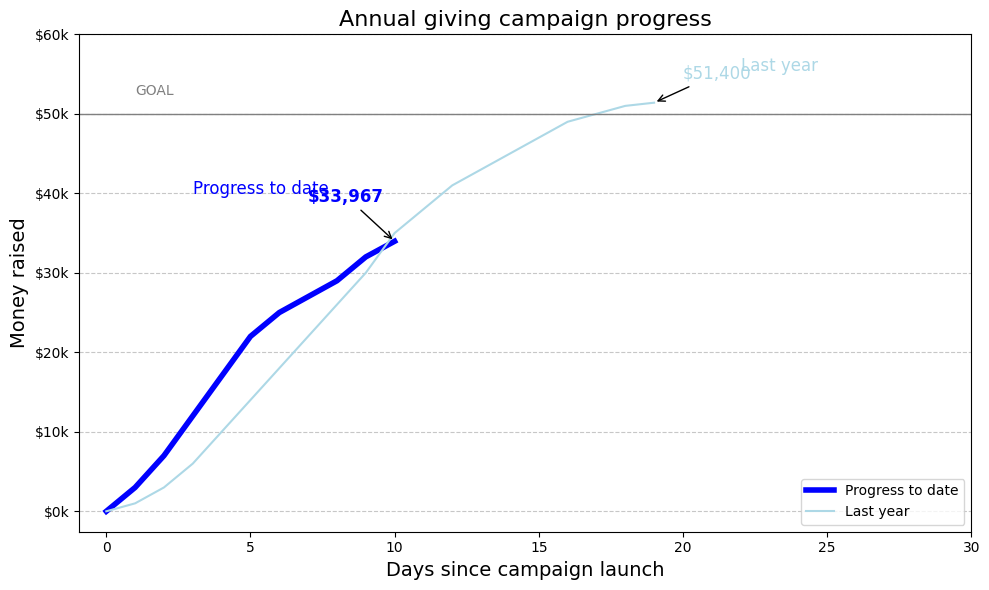

In [ ]:
# Sample data
days = np.arange(0, 30)
progress_to_date = np.array([0, 3000, 7000, 12000, 17000, 22000, 25000, 27000, 29000, 32000, 33967] + [np.nan]*19)
last_year_progress = np.array([0, 1000, 3000, 6000, 10000, 14000, 18000, 22000, 26000, 30000, 35000, 38000, 41000, 43000, 45000, 47000, 49000, 50000, 51000, 51400] + [np.nan]*10)

plt.figure(figsize=(10,6))

# Plot progress to date
valid_days = ~np.isnan(progress_to_date)
plt.plot(days[valid_days], progress_to_date[valid_days], linewidth=4, label='Progress to date', color='blue')

# Plot last year progress
valid_days_ly = ~np.isnan(last_year_progress)
plt.plot(days[valid_days_ly], last_year_progress[valid_days_ly], linewidth=1.5, label='Last year', color='lightblue')

# Goal line
goal = 50000
plt.axhline(goal, color='gray', linewidth=1)
plt.text(1, goal + 2000, 'GOAL', color='gray', fontsize=10, verticalalignment='bottom')

# Annotations with better positioning and arrows
plt.annotate(f"${progress_to_date[10]:,.0f}", 
             xy=(days[10], progress_to_date[10]), 
             xytext=(days[10]-3, progress_to_date[10]+5000),
             arrowprops=dict(facecolor='blue', arrowstyle='->'),
             color='blue', fontsize=12, fontweight='bold')
plt.text(days[10]-7, progress_to_date[10]+6000, 'Progress to date', color='blue', fontsize=12)

plt.annotate(f"${last_year_progress[19]:,.0f}", 
             xy=(days[19], last_year_progress[19]), 
             xytext=(days[19]+1, last_year_progress[19]+3000),
             arrowprops=dict(facecolor='lightblue', arrowstyle='->'),
             color='lightblue', fontsize=12)
plt.text(days[19]+3, last_year_progress[19]+4000, 'Last year', color='lightblue', fontsize=12)

# Labels and title
plt.title('Annual giving campaign progress', fontsize=16)
plt.xlabel('Days since campaign launch', fontsize=14)
plt.ylabel('Money raised', fontsize=14)
plt.xticks(np.arange(0, 31, 5))
plt.yticks(np.arange(0, 61000, 10000), [f"${x/1000:.0f}k" for x in np.arange(0, 61000, 10000)])

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()
